In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import scipy.stats as ss
from torch.distributions import Normal
import matplotlib.pylab as plt

In [2]:
torch.set_default_dtype(torch.float64)

In [3]:
class tOU:
    def __init__(self, t0, t1, z0, alpha, beta, m0, r, sigma, timegrid=False, dN=500):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.alpha = alpha
        """
            check whether every element in sigma is positive
        """  
        self.beta = beta
        assert all(sigma > 0), "variance must be positive"
        self.sigma = sigma
        assert alpha.shape[0] == beta.shape[0], "parameter dimension must be equal"
        
        self.m0 = m0
        assert all(r > 0), "r must be positive"
        self.r = r
        
        D = alpha.shape[0]
        if timegrid == True:
            self.pts = torch.linspace(t0, t1, dN).repeat(D, 1)
        else:
            self.pts = torch.sort(torch.cat([(t1 - t0) * torch.rand(D, dN-2) + t0, torch.tensor([self.t0, self.t1]).repeat(D,1)], axis=1), axis=1)[0]
        self.trj, self.dt = self.path()
    
    def path(self):
        
        # Get parameters
        alpha = self.alpha
        beta = self.beta
        sigma = self.sigma
        r = self.r
        m0 = self.m0
        z0 = self.z0
        t = self.pts
    
        def mean(x, dt, t0, alpha, beta, m0, r):
            """
                t0: we always start our process from t = 0
            """

            b_t = alpha * ( (t0[:,0].reshape(-1, 1) + 1) ** beta  - 1) + m0 \
                     - (alpha  * ((t0[:, 1].reshape(-1, 1) + 1) ** beta - 1) + m0 ) * torch.exp(r * dt.reshape(-1, 1))

            return (x.reshape(-1, 1) - b_t) * torch.exp(-r * dt.reshape(-1, 1))

        def std(t, r, sigma):
            return torch.sqrt(variance(t, r, sigma))

        def variance(t, r, sigma):
            dt = torch.diff(t)
            return sigma * sigma * (1 - torch.exp(-2 * r * dt)) / (2*r)

        alpha, beta, m0, r, sigma = params

        assert t.shape[1] > 1

        normal = Normal(loc=0., scale=1.)
        x = normal.sample(t.size())

        if torch.is_tensor(z0):
            x[:, 0] = z0.flatten()
        else:
            x[:, 0] = z0

        t0 = t - t[:, 0].reshape(-1, 1)

        dt = torch.diff(t)

        scale = std(t, r.reshape(-1,1), sigma.reshape(-1, 1))

        x[:, 1:] = x[:, 1:] * scale

        for i in range(1, x.shape[1]):
            x[:, i] += mean(x[:, i-1], dt[:, i-1], t0[:, i-1:i+1], alpha, beta, m0, r).flatten()


        return x, dt
    

In [4]:
def tou_gradient(t, x, params):
    
    """Calculates log likelihood of a path"""
    
    def mean(x, t, alpha, beta, m0, r):
        """
            t0: we always start our process from t = 0
        """
        t0 = t - t[:, 0].reshape(-1, 1)
        dt = torch.diff(t)
        m_t = alpha * ( (t0[:, :-1] + 1) ** beta  - 1) + m0 \
                - (alpha * ((t0[:, 1:] + 1) ** beta - 1 ) + m0) * torch.exp(r * dt)

        return (x - m_t) * torch.exp(-r * dt)
    
    def std(t, r, sigma):
        return torch.sqrt(variance(t, r, sigma))

    def variance(t, r, sigma):
        dt = torch.diff(t)
        return sigma * sigma * (1 - torch.exp(-2 * r * dt)) / (2*r)

    
    params_ = Variable(params, requires_grad=True)
    alpha, beta, m0, r, sigma = params_
    
    mu = mean(x[:, :-1], t, alpha, beta, m0, r)
    var = std(t, r, sigma)
    
    
    LL = torch.sum(Normal(loc=mu, scale=var).log_prob(x[:, 1:]), axis=1)
    LL.backward(torch.tensor([1.]).repeat(x.shape[0]))


    return {'alpha':params_.grad[0].clone().detach(), 'beta':params_.grad[1].clone().detach(), 
            'm0':params_.grad[2].clone().detach(), 'r':params_.grad[3].clone().detach(), 
            'LL':LL.clone().detach().data}


In [82]:
alpha = torch.tensor([0.633, -0.633])
beta = torch.tensor([3.59, 3.59])
m0 = torch.tensor([1.79, 1.79])
r = torch.tensor([1.124, 1.124])
sigma = torch.tensor([1., 1.])

In [83]:
params = torch.stack([alpha, beta, m0, r, sigma]).view(-1, 2, 1)

In [84]:
alpha, beta, sigma, m0, r = params

In [85]:
sde = tOU(t0=0., t1=2., z0=0., alpha=alpha, beta=beta, sigma = sigma, m0 = m0, r=r, timegrid=False, dN=1000)

In [86]:
def m_of_t(t, params):
    t0 = t - t[:, 0].reshape(-1, 1)
    alpha, beta, r, m0, sigma = params
    
    return alpha * ( (t0 + 1) ** beta - 1 ) + m0

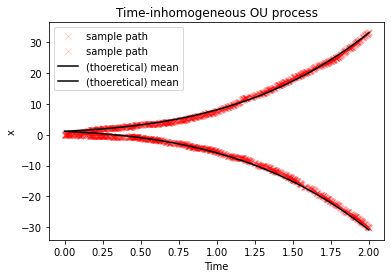

In [87]:
plt.title("Time-inhomogeneous OU process")
plt.plot(sde.pts.T, sde.trj.T, 'rx', alpha=0.2,  label='sample path')
plt.plot(sde.pts.T, m_of_t(sde.pts, params).T, color='black', label='(thoeretical) mean' )
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.show()

In [171]:
alpha_ = torch.zeros((2, 1))
beta_ = torch.ones((2, 1)) 
m0_ = torch.randn((2, 1))
r_ = torch.ones((2, 1))
sigma_ = torch.ones((2, 1))


learning_rate = 0.00001

for i in range(1501):
    params = torch.stack([alpha_, beta_, m0_, r_, sigma_]).view(-1, 2, 1)
    
    lr = learning_rate
    update = tou_gradient(sde.pts, sde.trj, params)
    
    alpha_ += learning_rate * update['alpha']
    m0_ += learning_rate * update['m0']
    
    beta_ += learning_rate * update['beta']
    r__  = r_ + learning_rate * update['r']
    
    while any(r__ < 0):
        for d in range(r_.shape[0]):
            if r__[d] < 0:
                while r__[d] < 0:
                    r__[d] = r_[d] + lr * update['r'][d]
                    lr *= 0.5
#             if beta__[d] < 0:
#                 while beta__[d] < 0:
#                     beta__[d] = beta_[d] + lr * update['beta'][d]
#                     lr *= 0.5
    r_ = r__
#     beta_ = beta__
    
    if i % 500 == 0:
        print('alpha = ', alpha_.data.numpy(), "beta = ", beta_.data.numpy(),
              "r = ", r_.data.numpy(), "m0 = ", m0.data.numpy(), 'LL = ', update['LL'])

alpha =  [[ 0.0013079 ]
 [-0.00125381]] beta =  [[1.]
 [1.]] r =  [[0.99059215]
 [0.99109282]] m0 =  [[1.124]
 [1.124]] LL =  tensor([811.7473, 911.7627])
alpha =  [[ 1.48236084]
 [-0.88231523]] beta =  [[2.81034135]
 [3.26452968]] r =  [[ 5.78900145]
 [14.44650129]] m0 =  [[1.124]
 [1.124]] LL =  tensor([1880.6462, 1901.2531])
alpha =  [[ 1.19018144]
 [-0.86870997]] beta =  [[3.02173831]
 [3.19836291]] r =  [[ 5.74220225]
 [14.23656215]] m0 =  [[1.124]
 [1.124]] LL =  tensor([1913.0084, 1684.0922])
alpha =  [[ 1.01600714]
 [-0.84635224]] beta =  [[3.17330473]
 [3.22492474]] r =  [[ 5.72448693]
 [14.03463289]] m0 =  [[1.124]
 [1.124]] LL =  tensor([1925.4637, 1711.7205])


In [172]:
alpha_, beta_, m0_, r_

(tensor([[ 1.0160],
         [-0.8464]]),
 tensor([[3.1733],
         [3.2249]]),
 tensor([[0.5537],
         [1.4976]]),
 tensor([[ 5.7245],
         [14.0346]]))

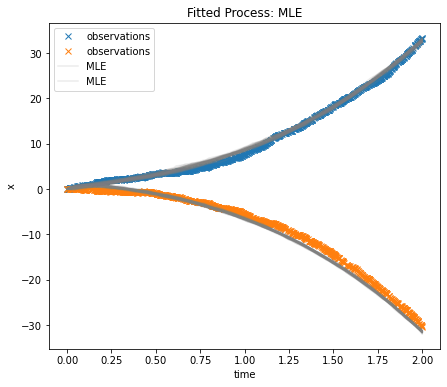

In [173]:
plt.figure(figsize=(7,6))
plt.title("Fitted Process: MLE")
plt.plot(sde.pts.T, sde.trj.T, 'x', label='observations')
for i in range(50):
    vi_ = tOU(0., 2., 0., *torch.stack([alpha_, beta_, m0_, r_, sigma_]).view(-1, 2, 1), dN=100)
    plt.plot(vi_.pts.T, vi_.trj.T, alpha=0.15, color='grey')
    if i == 49:
        plt.plot(vi_.pts.T, vi_.trj.T, alpha=0.15, color='grey', label='MLE')
plt.xlabel("time")
plt.ylabel("x")
plt.legend()
plt.show()

In [ ]:
def path(t, x0, params):
    
    def mean(x, dt, t0, alpha, beta, m0, r):
        """
            t0: we always start our process from t = 0
        """

        b_t = alpha * ( (t0[:,0].reshape(-1, 1) + 1) ** beta  - 1) + m0 \
                 - (alpha  * ((t0[:, 1].reshape(-1, 1) + 1) ** beta - 1) + m0 ) * torch.exp(r * dt.reshape(-1, 1))

        return (x.reshape(-1, 1) - b_t) * torch.exp(-r * dt.reshape(-1, 1))
    
    def std(t, r, sigma):
        return torch.sqrt(variance(t, r, sigma))

    def variance(t, r, sigma):
        dt = torch.diff(t)
        return sigma * sigma * (1 - torch.exp(-2 * r * dt)) / (2*r)
    
    alpha, beta, m0, r, sigma = params
    
    assert t.shape[1] > 1
    
    normal = Normal(loc=0., scale=1.)
    x = normal.sample(t.size())
   
    if torch.is_tensor(x0):
        x[:, 0] = x0.flatten()
    else:
        x[:, 0] = x0
    
    t0 = t - t[:, 0].reshape(-1, 1)

    dt = torch.diff(t)
    
    scale = std(t, r.reshape(-1,1), sigma.reshape(-1, 1))
    
    x[:, 1:] = x[:, 1:] * scale

    for i in range(1, x.shape[1]):
        x[:, i] += mean(x[:, i-1], dt[:, i-1], t0[:, i-1:i+1], alpha, beta, m0, r).flatten()
    
    
    return x, dt
    